# Step 1 - Text Preprocessing

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# !pip3 install langdetect
# !pip3 install deep_translator

import langdetect
from deep_translator import GoogleTranslator
import string

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def show_percentage(m, n):
    """Function to monitor the operation of the cycle."""
    clear_output(wait=True)
    k = m / (n - 1)
    percent = int(k * 100)
    print('[' + 'x'*percent + '-'*(100 - percent) + ']' + " {:.2%}".format(k))
    print("{}/{} complete".format(m + 1, n))

### Get the Data

##### Data source: https://www.kaggle.com/adarshsng/predicting-job-type-category-by-job-description

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/raw_data.csv")
df.head()

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations


##### Explore the data.

In [ ]:
df.isnull().sum()

job_no             0
job_description    0
job_type           0
category           0
dtype: int64

In [ ]:
df['job_description'][0][:300]

" Zest Scientific is searching for an accomplished Scientific Sales professional in the Netherlands. This territory will play a pivotal role as the company increases their presence across Europe, presenting a wealth of untapped potential. Our client is internationally recognized for providing 'best i"

In [ ]:
df.shape

(17657, 4)

In [ ]:
df['job_type'].value_counts()

Permanent             15777
Contract/Interim       1414
Contract/Temp           305
Temporary/Seasonal      113
Any                      25
Part-Time                23
Name: job_type, dtype: int64

In [ ]:
df['category'].value_counts()

Pharmaceutical, Healthcare and Medical Sales    4507
Clinical Research                               3172
Science                                         2932
Manufacturing & Operations                      2235
Regulatory Affairs                              1163
Pharmaceutical Marketing                        1071
Data Management and Statistics                   829
Quality-assurance                                703
Medical Information and Pharmacovigilance        561
Medical Affairs / Pharmaceutical Physician       458
Pharmacy                                          26
Name: category, dtype: int64

In [ ]:
### we can drop a column with id's, it is not useful

##### We see that there are no outliers in the dataset, it contains 17657 lines. The job_description column contains a description of a job / profession. From the set of categories it is clear that they are all related to medicine. Job information can be classified into 6 types and 11 categories. The column with the description of the work contains texts not only in English. I have previously researched that about 5,000 texts are not written in English. This is quite a significant part of the data, so we will not just throw them out, but instead translate all the texts into English. 

### Translate foreign texts 

In [ ]:
def translate_to_eng(text):
    translated = GoogleTranslator(source="auto", target="en").translate(text)
    return translated

In [ ]:
for i in range(len(df)):
    text = df.iloc[i]["job_description"]
    if langdetect.detect(text) != "en":
        # NotValidPayload: . --> text must be a valid text with maximum 5000 character, otherwise it cannot be translated
        if len(text) > 4900:
            new_text = ""
            for j in range(len(text) // 4900 + 1):
                text_j = text[j * 4900 : (j + 1) * 4900]
                new_text += translate_to_eng(text_j)
            df.iloc[i]["job_description"] = new_text
        else:
            df.iloc[i]["job_description"] = translate_to_eng(text)
    show_percentage(i, len(df))

[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] 100.00%
17657/17657 complete


##### When working with a jupyter notebook, sometimes the kernel dies and needs to be rebooted, and we lose all temporary data. In order not to waste time on "heavy" sections of the code after rebooting, we will save intermediate results. 

In [ ]:
df.to_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/translated_data.csv", index=False)

### Clear the Text

In [ ]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [ ]:
df['job_description'] = df['job_description'].apply(lambda x: remove_punctuation(x))
# lowering the text
df['job_description'] = df['job_description'].apply(lambda x: x.lower())
df['job_description'][0][:300]

' zest scientific is searching for an accomplished scientific sales professional in the netherlands this territory will play a pivotal role as the company increases their presence across europe presenting a wealth of untapped potential our client is internationally recognized for providing best in cl'

### Tokenization

In [ ]:
df['job_description'] = df['job_description'].apply(lambda x: word_tokenize(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'is', 'searching', 'for', 'an', 'accomplished', 'scientific', 'sales', 'professional', 'in', 'the', 'netherlands', 'this', 'territory', 'will', 'play', 'a', 'pivotal', 'role']


In [ ]:
def clear(lst):
    """The function removes one-letter words and words that contain numbers."""
    new_lst = []
    for word in lst:
        if word.isalpha() and len(word) > 1:
            new_lst.append(word)
    return new_lst

In [ ]:
df['job_description'] = df['job_description'].apply(lambda x: clear(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'is', 'searching', 'for', 'an', 'accomplished', 'scientific', 'sales', 'professional', 'in', 'the', 'netherlands', 'this', 'territory', 'will', 'play', 'pivotal', 'role', 'as']


### Remove stop words

In [ ]:
stopwords_en = nltk.corpus.stopwords.words('english')

def remove_stopwords(lst):
    output = [i for i in lst if i not in stopwords_en]
    return output

In [ ]:
df['job_description'] = df['job_description'].apply(lambda x: remove_stopwords(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'searching', 'accomplished', 'scientific', 'sales', 'professional', 'netherlands', 'territory', 'play', 'pivotal', 'role', 'company', 'increases', 'presence', 'across', 'europe', 'presenting', 'wealth', 'untapped']


### Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(lst):
    lemm_text = [lemmatizer.lemmatize(word) for word in lst]
    return lemm_text

In [ ]:
df['job_description'] = df['job_description'].apply(lambda x: lemmatize(x))
print(df['job_description'][0][:20])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['zest', 'scientific', 'searching', 'accomplished', 'scientific', 'sale', 'professional', 'netherlands', 'territory', 'play', 'pivotal', 'role', 'company', 'increase', 'presence', 'across', 'europe', 'presenting', 'wealth', 'untapped']


## Visualization
##### We present in the form of wordcloud separate words and bigrams that are most common in the corpus. 

In [ ]:
def build_wordcloud(text, collocations):
    wordcloud = WordCloud(
        max_words=50,
        font_step=2,
        max_font_size=500,
        background_color='black',
        collocations=collocations
    ).generate(text)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud);
    plt.show()

In [ ]:
def visualize_category(df, collocations):
    """Displays the most common words for each dataset category."""
    for label in df['category'].unique():
        print(label)
        text = ''
        for msg in df[df['category'] == label]['job_description']:
            text += " ".join(msg)
        build_wordcloud(text, collocations)

#### Common words

Pharmaceutical, Healthcare and Medical Sales


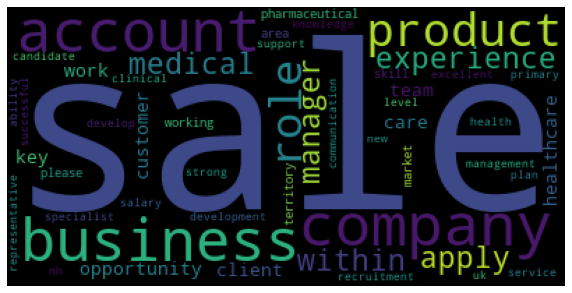

Clinical Research


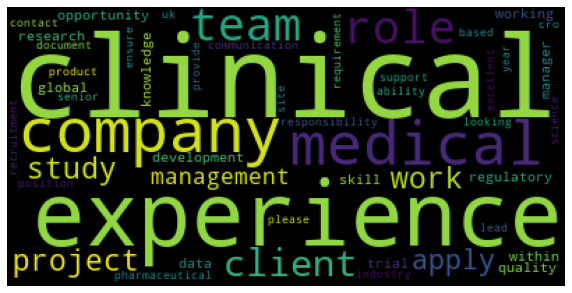

Pharmaceutical Marketing


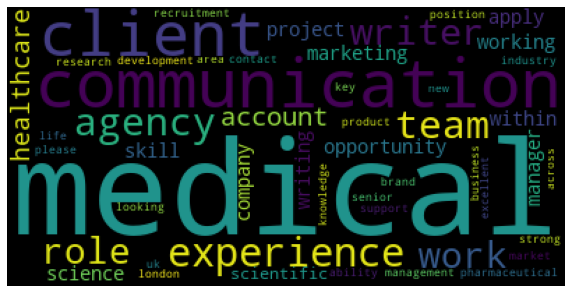

Manufacturing & Operations


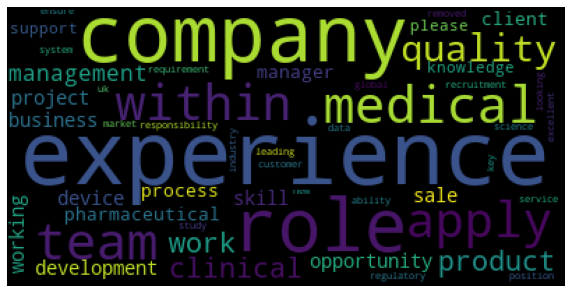

Science


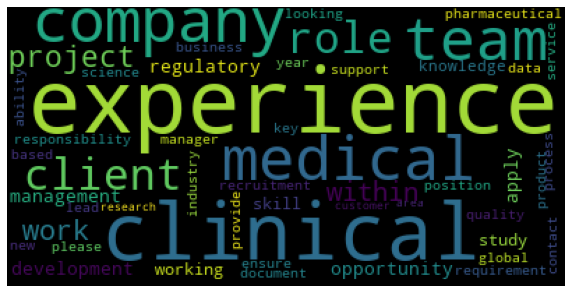

Medical Affairs / Pharmaceutical Physician


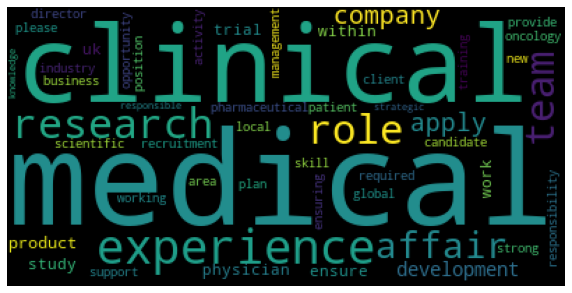

Regulatory Affairs


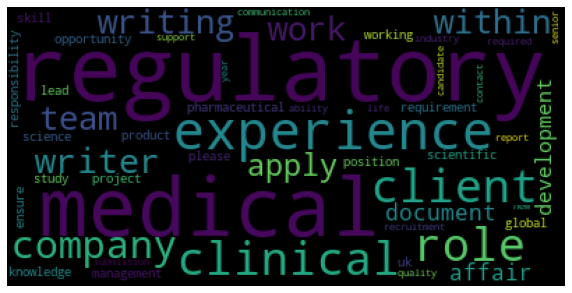

Medical Information and Pharmacovigilance


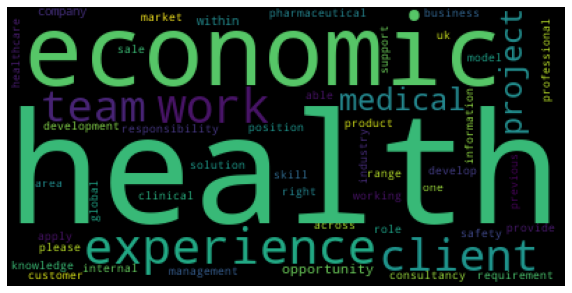

Data Management and Statistics


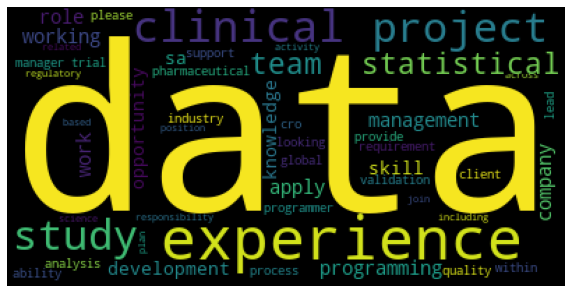

Quality-assurance


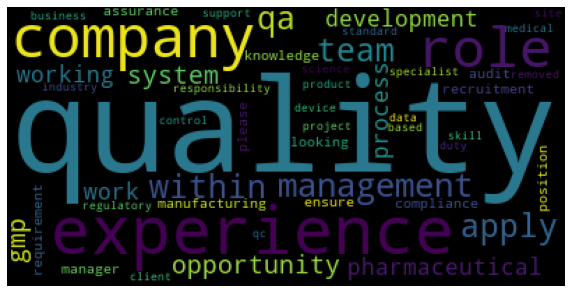

Pharmacy


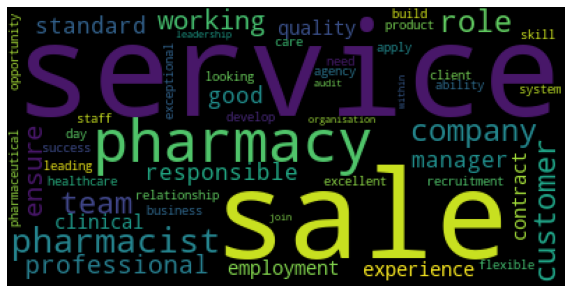

In [ ]:
visualize_category(df, False)

#### Bi-grams

Pharmaceutical, Healthcare and Medical Sales


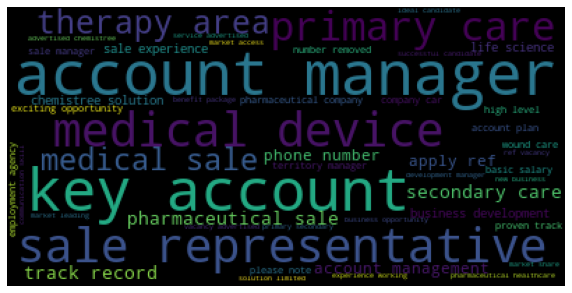

Clinical Research


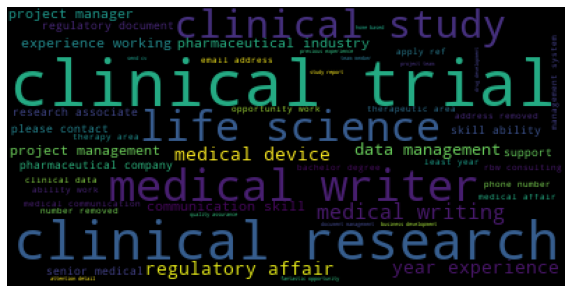

Pharmaceutical Marketing


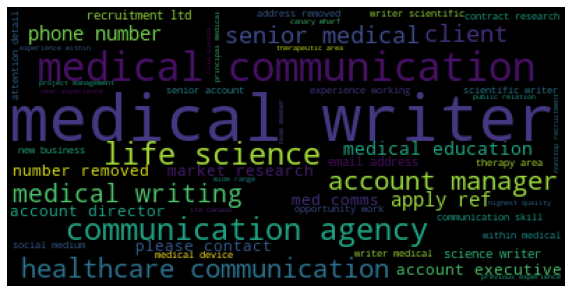

Manufacturing & Operations


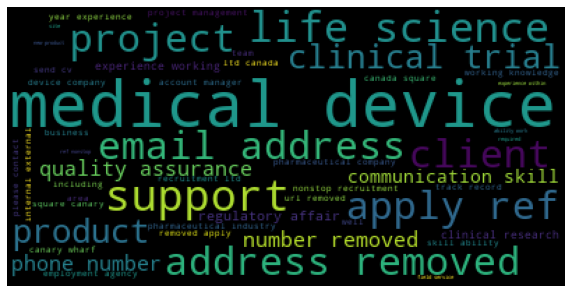

Science


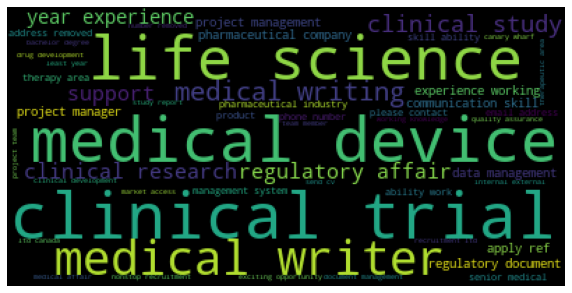

Medical Affairs / Pharmaceutical Physician


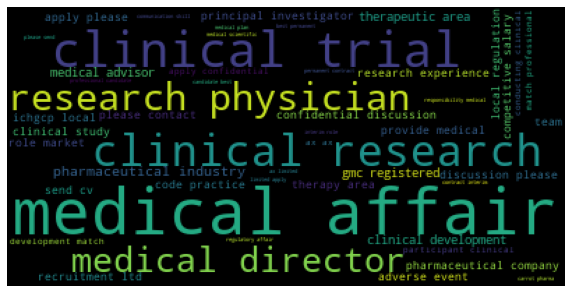

Regulatory Affairs


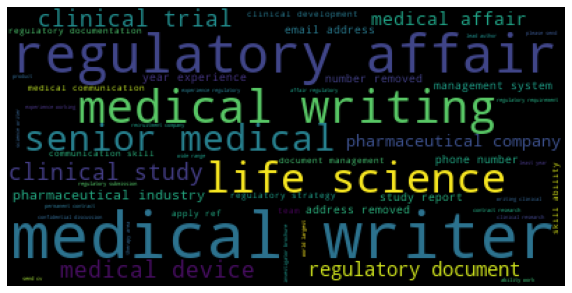

Medical Information and Pharmacovigilance


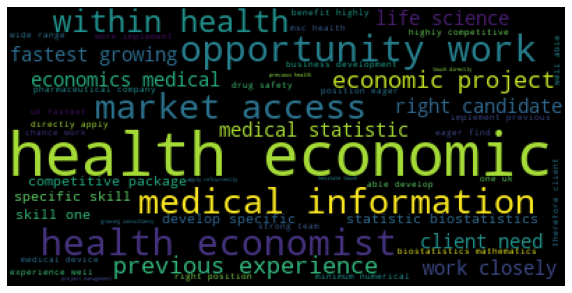

Data Management and Statistics


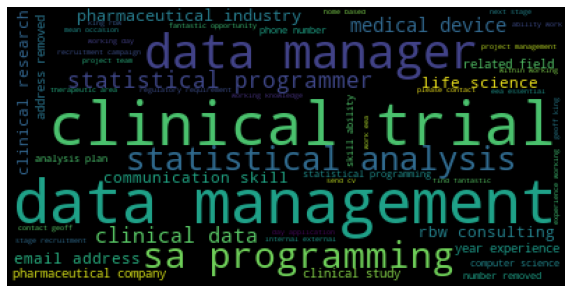

Quality-assurance


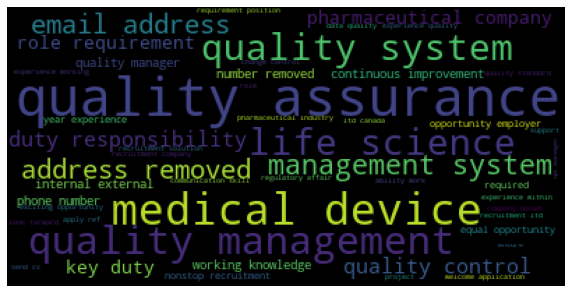

Pharmacy


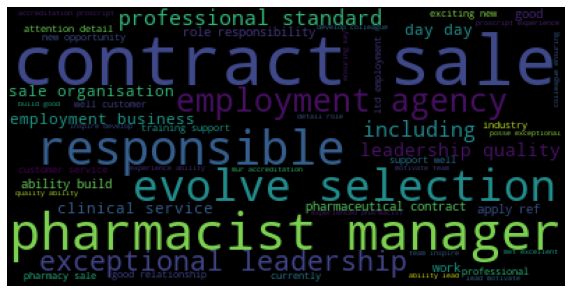

In [ ]:
visualize_category(df, True)

In [ ]:
# save preprocessed data
df.to_csv("/content/gdrive/MyDrive/practice_nlp_2022/data/preprocessed_data.csv", index=False)